In [1]:
#visualization of data
from PIL import Image
import matplotlib.pyplot as plt 
#technical tool to for saving temporary files
import os
import datetime
import time
#main libraries
import numpy as np
from pandas import DataFrame, ExcelWriter
import tensorflow as tf
import datasets

#prevent tensorflow from allocating all GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
try:tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:pass

print("GPU:", physical_devices)
print("TensorFlow version:", tf.__version__)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.1


In [2]:
def visualize(img_data, path=None): #input can be image or batch or tensorflow iterator
    temp = np.array(img_data)
    data_shape = temp.shape
    temp = temp.reshape((-1,data_shape[-3],data_shape[-2],data_shape[-1]))
    fig, ax = plt.subplots(ncols=len(temp), figsize=(10, 10), squeeze=False)
    for indx, img in enumerate(temp):
        ax[0][indx].imshow(img)
    return data_shape

In [3]:
#model to upsampling low resolution images
#getting as input any image and giving as output image with resolution*8


conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }



def block(ft=2, ks=3):
    def her(in_x):
        temp = tf.keras.layers.Conv2D(filters=ft,
                                      kernel_size=ks,
                                      strides=1,
                                      **conv_args)(in_x)
        temp = tf.keras.layers.BatchNormalization()(temp)
        temp = tf.keras.layers.ReLU()(temp)
        #temp = tf.keras.layers.Conv2D(filters=ft,
        #                              kernel_size=ks,
        #                              strides=1,
        #                              **conv_args)(temp)
        #temp = tf.keras.layers.BatchNormalization()(temp)
        #temp = tf.math.add(in_x, temp)
        #temp = tf.keras.layers.BatchNormalization()(temp)
        #temp = tf.keras.layers.ReLU()(temp)
        return temp
    return her



def hourglass(fr=1):
    def her(in_x):
        k = 1
        store = {}
        temp = tf.keras.layers.Conv2D(filters=1,
                                       kernel_size=3,
                                       strides=2,
                                       **conv_args)(in_x)
        temp = tf.keras.layers.BatchNormalization()(temp)
        temp = block(1)(temp)
        for i in range(2,9):
            k = i
            temp = tf.keras.layers.Conv2D(filters=fr*k,
                                       kernel_size=3,
                                       strides=2,
                                       **conv_args)(temp)
            temp = tf.keras.layers.BatchNormalization()(temp)
            temp = block(fr*k)(temp)
            store[i] = temp
        temp = block(fr*k)(temp)
        temp = block(fr*k)(temp)
        keypoint = temp
        temp = block(fr*k)(temp)
        for i in range(7,0,-1):
            k = i
            temp = tf.math.add(temp, store.pop(i+1))
            temp = tf.keras.layers.Conv2DTranspose(filters=fr*k,
                                                   kernel_size=3,
                                                   strides=2,
                                                   **conv_args)(temp)
            temp = tf.keras.layers.BatchNormalization()(temp)
            temp = block(fr*k)(temp)
            keypoint = tf.keras.layers.Conv2DTranspose(filters=fr*k,
                                                       kernel_size=2,
                                                       strides=2,
                                                       **conv_args)(keypoint)
            keypoint = tf.keras.layers.BatchNormalization()(keypoint)
            keypoint = tf.math.add(keypoint, temp)
        k=1
        temp = tf.keras.layers.Conv2DTranspose(filters=1,
                                       kernel_size=3,
                                       strides=2,
                                       **conv_args)(temp)
        temp = tf.keras.layers.BatchNormalization()(temp)
        keypoint = tf.keras.layers.Conv2DTranspose(filters=1,
                                                       kernel_size=2,
                                                       strides=2,
                                                       **conv_args)(keypoint)
        keypoint = tf.keras.layers.BatchNormalization()(keypoint)
        temp = tf.math.add(temp, keypoint)
        temp = tf.keras.layers.BatchNormalization()(temp)
        temp = block(1)(temp)
        return temp
    return her



def Generator():  
    input = tf.keras.Input(shape=[None, None, 3],
                         ragged=True)
    input = input.to_tensor(name='input_image')
    
    x = tf.keras.layers.Conv2D(filters=1,
                               kernel_size=1,
                               strides=1,
                               **conv_args)(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=3,
                               kernel_size=3,
                               strides=1,
                               **conv_args)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=3,
                               kernel_size=3,
                               strides=1,
                               **conv_args)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x1 = x
    x = hourglass(1)(x)
    x2 = x
    x = tf.math.add(x1,-x2)
    del x1
    x = tf.keras.layers.BatchNormalization()(x)
    x = hourglass(1)(x)
    x = tf.math.add(x,x2)
    del x2
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=3,
                               kernel_size=3,
                               strides=1,
                               **conv_args)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(max_value=1)(x)

    return tf.keras.Model(inputs=input, outputs=x, name="generator")

In [4]:
#initialize generator
generator = Generator()

#summary of trainable weight
generator.summary()
#plot the model grathp
#tf.keras.utils.plot_model(generator, show_shapes = True)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   4           ['input_2[0][0]']                
                                1)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   4          ['conv2d[1][0]']                 
 alization)                     1)                                                        

In [5]:
#initialization and tuning of problem optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, 
                                               beta_1=0.9)
#model saves manager
checkpoint_dir = "./training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                generator=generator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir , max_to_keep=4)

In [6]:
if True: 
    try:
        checkpoint.restore(ckpt_manager.latest_checkpoint)
    except Exception as ex:
        print(ex)

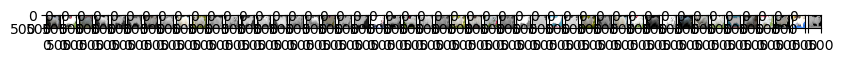

In [7]:
path=r"C:\Users\common\source\Jupyter\silhouettes\dataset\512_20240207"
folder_list = list(os.walk(path))

def img_gen(butch=1):
    rng = np.random.default_rng()
    folder_list = list(os.walk(path))
    files_list = []
    for folder in folder_list:
        if folder[1] != []: continue
        file_path = [os.path.join(folder[0], folder[-1][0])]
        file_path.append(os.path.join(folder[0], folder[-1][1]))
        files_list.append(file_path)
    while True:
        sample_in = []
        sample_out = []
        for i in range(butch):
            pair = files_list[int(rng.random() * len(files_list))]
            img1 = tf.keras.utils.load_img(pair[0])
            img2 = tf.keras.utils.load_img(pair[1])
            pair = np.array([img1,img2])/255
            if rng.random() < 0.5:
                pair = np.dot(pair[...,:3], [0.2989, 0.5870, 0.1140])
                pair = pair.reshape((2,512,512,1))
                pair = np.repeat(pair, 3, axis=-1)
            if rng.random() < 0.5:
                pair = np.flip(pair, 2)
            k = rng.random()
            if k > 0.5:
                pair[0] += -np.min(pair[0])*rng.random()
                pair[0] /= np.max(pair[0])*(3-rng.random())/2
            else:
                pair[0] += 0.25-k
                pair[0] = np.maximum(pair[0], 0)
                pair[0] = np.minimum(pair[0], 1)
            if rng.random()<0.5:
                pair = tf.image.resize(pair, (128,128))
                pair = tf.image.resize(pair,(512,512))
            sample_in.append(pair[0])
            sample_out.append(pair[1])
        
        del pair, img1, img2
        yield (np.array(sample_in),np.array(sample_out))

get_img = img_gen(48)

test = next(get_img)
visualize(test[0])
del test

In [8]:
EPOCHS = 10
generator.compile(optimizer=generator_optimizer,
                  loss=tf.keras.metrics.mean_absolute_error,
                  metrics=['mse'])

folder = f"result/{datetime.datetime.now().strftime('%Y%m%d')}"
os.makedirs(folder, exist_ok=True)

perios = 1
for i in range(EPOCHS//perios):
    generator.fit(get_img,
                  steps_per_epoch=100,
                  epochs=perios)
    ckpt_manager.save()
    
    im = Image.open(r"C:\Users\common\source\Jupyter\silhouettes\result\input_2.jpg")
    im = im.resize((512,512))
    im = np.array([im])/255
    result = generator(im)
    name = os.path.join(folder,f"frame_{datetime.datetime.now().strftime('%H%M%S')}.jpg")
    result = result.numpy()*255
    result = Image.fromarray(result[0].astype(np.uint8))
    result.save(name)
    del im, result, name

100/100 [==============================] - 252s 3s/step - loss: 0.0133 - mse: 0.0078


(1, 512, 512, 3)

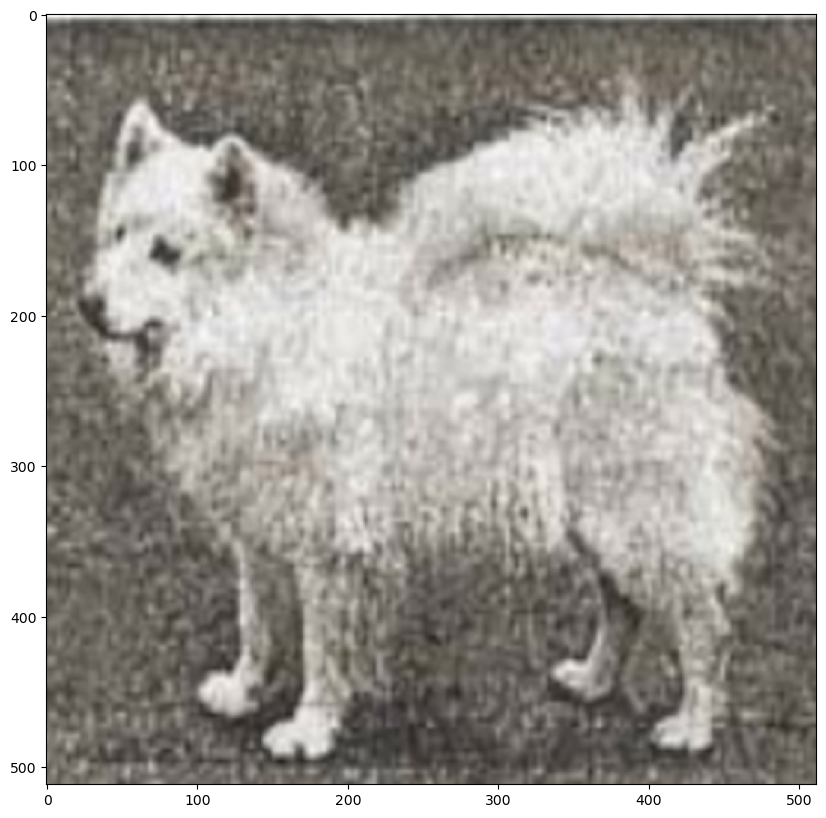

In [9]:
im = Image.open(r"C:\Users\common\source\Jupyter\silhouettes\result\input_4.jpg")
im = im.resize((512,512))
im = np.array([im])/255

#im = test[0][0] + 0.25
#im = im+0.5
#im = np.minimum(im, 1)
visualize(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0 0.0
(1, 512, 512, 3) 
 result/24-1230.jpg


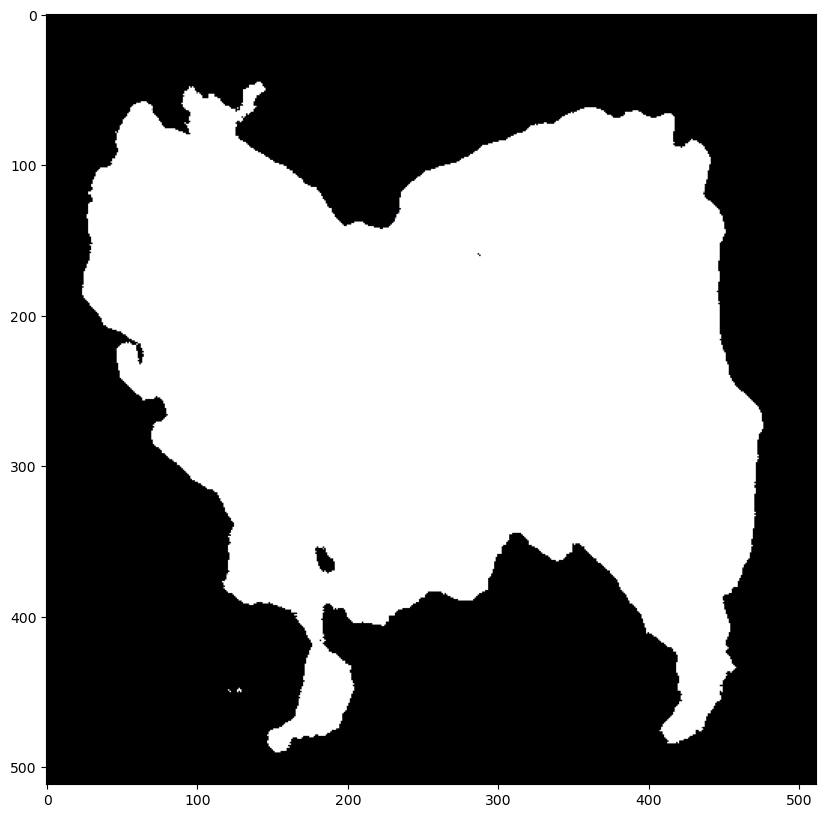

In [10]:
result = generator(im)
print(np.max(result), np.min(result))
name = f"result/24-{datetime.datetime.now().strftime('%H%M')}.jpg"
result = result.numpy()*255
print(result.shape, "\n",name)
visualize(result)
result = Image.fromarray(result[0].astype(np.uint8))
result.save(name)

In [11]:
if False:
    weights_folder = "result/20240222-1/"
    postfix = "age_n"
    os.makedirs(weights_folder, exist_ok=True)
    
    generator.save_weights(weights_folder + 'generator' + postfix)

    print("files:\n",
         weights_folder + 'generator_' + postfix)